# 2022 EY Challenge

## Frog Data

This notebook demonstrates how to extract frog location data directly from the Global Biodiversity Information Facility (GBIF) API. The GBIF occurrence dataset combines data from a wide array of sources, including specimen-related data from natural history museums, observations from citizen science networks, and automated environmental surveys. The entire GBIF dataset can be visualised on the [GBIF interactive map website](https://www.gbif.org/occurrence/map). While the Planetary Computer does make periodic snapshots of the GBIF data available, the specificity of our query workload makes it more efficient to query the GBIF API directly. If you would prefer to access the data through the Planetary Computer, see the documentation [here](https://planetarycomputer.microsoft.com/dataset/gbif#overview). This notebook will walk through the process of accessing the GBIF data through the GBIF API.




In [14]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting tools
import matplotlib.pyplot as plt

# Data science tools
import pandas as pd
import numpy as np

# Geospatial tools
import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, Polygon

# API tools
import requests
import json


### Area Definition

For this demonstration, we will constrain our search to frogs in the Penrith NSW area. This gives a varied landscape of bushland, plains, rivers, and urban areas.

Text(0.5, 1.0, 'Penrith, NSW')

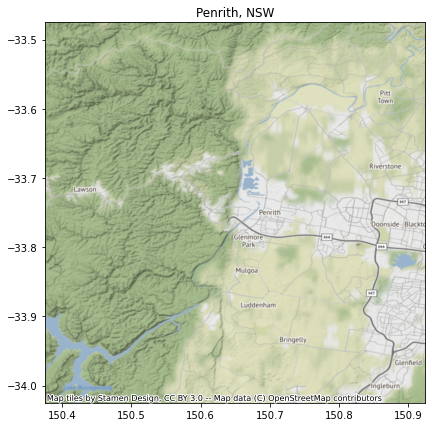

In [15]:
# Penrith, NSW
region_name = 'Penrith, NSW'
min_lon, min_lat = (150.40, -34.00)  # Lower-left corner
max_lon, max_lat = (150.90, -33.50)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Plot map of region
crs = {'init':'epsg:4326'}
fig, ax = plt.subplots(figsize = (7, 7))
ax.scatter(x=[min_lon, max_lon], y=[min_lat, max_lat], alpha=0)
cx.add_basemap(ax, crs=crs)
ax.set_title(region_name)

### Accessing the GBIF API

As previously mentioned, the frog location data will be accessed directly from the GBIF API, the documentation of which can be found [here](https://www.gbif.org/developer/summary). We will be utilising the GBIF API's 'search' service which is specified by the URL `https://api.gbif.org/v1/occurrence/search`, which we can interface with through the Python `requests` module. Later we will pass parameters to this service, but for now we can test it out by fetching the first 20 results of the database (20 records is the default limit, which we will learn how to change later). This is done with the `get` method of the requests module.

In [16]:
# Query the API
response = requests.get("https://api.gbif.org/v1/occurrence/search")
# Print the request status (200 = success)
print(f"Status: {response.status_code}")
# Convert response to a python dictionary
response = response.json()
print(f"Records returned: {len(response['results'])} of {response['count']}")
print(f"First record: {json.dumps(response['results'][0], indent=4, sort_keys=True)}")

Status: 200
Records returned: 20 of 1942128523
First record: {
    "acceptedScientificName": "Cyanistes caeruleus (Linnaeus, 1758)",
    "acceptedTaxonKey": 2487879,
    "basisOfRecord": "HUMAN_OBSERVATION",
    "catalogNumber": "192540296",
    "class": "Aves",
    "classKey": 212,
    "collectionCode": "naturgucker",
    "coordinateUncertaintyInMeters": 250.0,
    "country": "Germany",
    "countryCode": "DE",
    "crawlId": 220,
    "datasetKey": "6ac3f774-d9fb-4796-b3e9-92bf6c81c084",
    "day": 1,
    "decimalLatitude": 52.27853,
    "decimalLongitude": 8.890963,
    "eventDate": "2022-01-01T00:00:00",
    "extensions": {},
    "facts": [],
    "family": "Paridae",
    "familyKey": 9327,
    "gadm": {
        "level0": {
            "gid": "DEU",
            "name": "Germany"
        },
        "level1": {
            "gid": "DEU.10_1",
            "name": "Nordrhein-Westfalen"
        },
        "level2": {
            "gid": "DEU.10.30_1",
            "name": "Minden-L\u00fcbbec

The result of the API request is that we retrieved 20 results from a total of almost 2 billion!. Printed above is the first result. You can see the result contains comprehensive data on the occurrence. You may want to look up the species to see what it is commonly known as. 

### Performing a search query

#### All Frogs

Now that we know how to perform a basic GET request using the requests module, we can pass in parameters to refine our search. The query parameters of the search can be passed to the get request as a python dictionary, which we create below. For this demonstration, we will specify all frog occurences from 2015 to 2019 in the Richmond location. 

There are a few things to note when specifying parameters:
- Ranges are given as a single parameter value by concatenating a lower and an upper value with a comma i.e. "\<min_val\>,\<max_val\>"
- String fields like `order` and `species` need to be specified by their keys within the dataset, rather than raw text. For example, to filter for the order of Anura, we need to specify an `orderKey` value of "952", rather than an `order` value of "Anura". The keys are the same as the taxonKey which can be read from the URL when a query is specified on the [GBIF interactive map website](https://www.gbif.org/occurrence/map).

For a more detailed description of all possible query parameters, see the [GBIF documentation](https://www.gbif.org/developer/occurrence)

In [13]:
# Specify query parameters
parameters = {
    "year":"2015,2019", # Year range
    "orderKey":"952", # The order Anura (frogs) is indicated by key 952
    "decimalLatitude":f"{min_lat},{max_lat}", # Latitude range
    "decimalLongitude":f"{min_lon},{max_lon}" # Longitude range
}

response = requests.get("https://api.gbif.org/v1/occurrence/search", params = parameters).json()
print(f"Records returned: {len(response['results'])} of {response['count']}")

# Read results into a dataframe and display
results = (
    pd.DataFrame(response['results'])
    # Take relevant fields
    [['key','kingdom', 'phylum','order', 'family', 'genus', 'species',
       'decimalLongitude', 'decimalLatitude', 'stateProvince', 'year', 'month', 'day', 'eventDate']]
)
results.head()


Records returned: 20 of 5905


,key,kingdom,phylum,order,family,genus,species,decimalLongitude,decimalLatitude,stateProvince,year,month,day,eventDate
0,2423540290,Animalia,Chordata,Anura,Limnodynastidae,Limnodynastes,Limnodynastes peronii,150.619318,-33.744031,New South Wales,2019,1,28,2019-01-28T03:24:29
1,2432606330,Animalia,Chordata,Anura,Limnodynastidae,Limnodynastes,Limnodynastes tasmaniensis,150.700000,-33.500000,New South Wales,2019,1,28,2019-01-28T14:23:00
2,2432613667,Animalia,Chordata,Anura,Myobatrachidae,Uperoleia,NaN,150.700000,-33.500000,New South Wales,2019,1,28,2019-01-28T14:13:00
3,2432621835,Animalia,Chordata,Anura,Limnodynastidae,Limnodynastes,Limnodynastes peronii,150.600000,-33.700000,New South Wales,2019,1,16,2019-01-16T16:11:00
4,2432645368,Animalia,Chordata,Anura,Myobatrachidae,Uperoleia,NaN,150.700000,-33.500000,New South Wales,2019,1,21,2019-01-21T17:26:00


#### Restricting Species

The above query gathered all frogs in the given area, but for the challenge we will be restricting the model to 23 species. These species are found in the ['australian_frogs.csv'](australian_frogs.csv), along with their `speciesKey` which we will use to query the API. Note that not all 23 will be present for a given area.


So far we have only been able to access 20 records at a time. This is specified by the `limit` parameter (which defaults to 20 and cannot be more than 300). If the query has less than 300 results, then all can be retrieved in just one call to the API. However, if a query has more than 300 results we need to make a few sequential calls to the API, setting `limit=300` but varying the `offset` parameter. A limit of 300 and offset of 300, will get the second page of 300 results. So to reach the next page of results, we simply need to add 300 to the offset and repeat until the offset is greater than the count of all records. Another way of detecting the last page of results is by checking for when the `endOfRecords` attribute of the response object changes to `True`. 

Below we implement such a loop to collect all 1456 frog occurences from 2015 to 2019 in the Richmond location, saving each page of results to a dataframe.

In [17]:
frogs = pd.DataFrame()

limit = 300

parameters = {
    "year":"2015,2019", # Year range
    "orderKey":"952", # The order Anura (frogs) is indicated by order 952
    "decimalLatitude":f"{min_lat},{max_lat}", # Latitude range
    "decimalLongitude":f"{min_lon},{max_lon}", # Longitude range
    "limit":limit
}

offset = 0
while True:
    
    parameters['offset'] = offset
    response = requests.get("https://api.gbif.org/v1/occurrence/search", params = parameters).json()
    total = response['count']
    
    print(f"{offset} of {total}")
    
    frogs = frogs.append(
        pd.DataFrame(response['results'])
        # Take only relevant columns
        [['key','scientificName', 'acceptedScientificName', 'kingdom', 'phylum',
       'order', 'family', 'genus', 'species', 'genericName', 'specificEpithet',
       'decimalLongitude', 'decimalLatitude', 'stateProvince', 'year', 'month', 'day', 'eventDate']]
    )
    if response['endOfRecords']:
        break
    offset += limit
    
    

0 of 5905
300 of 5905
600 of 5905
900 of 5905
1200 of 5905
1500 of 5905
1800 of 5905
2100 of 5905
2400 of 5905
2700 of 5905
3000 of 5905
3300 of 5905
3600 of 5905
3900 of 5905
4200 of 5905
4500 of 5905
4800 of 5905
5100 of 5905
5400 of 5905
5700 of 5905


### Visualising the dataset

Below we can see the species distribution of all frog occurrences in Richmond, NSW.

<AxesSubplot:title={'center':'Count of Frog Occurrences by Species (Richmond NSW, 1890-2021)'}, xlabel='species'>

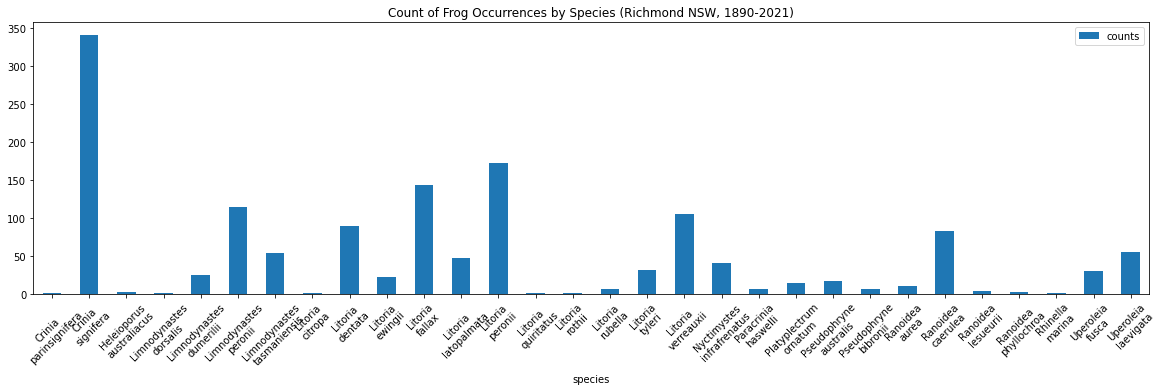

In [6]:
species_summary = (
    frogs
    .groupby(["species"]).count()
    [['key']]
    .rename(columns={'key':'counts'})
    # Format species names for plotting
    .reset_index()
    .assign(
        species = lambda x: x.species.str.replace(' ', '\n')
    )
    .set_index("species")
)

species_summary.plot.bar(
    rot=45, 
    title=f"Count of Frog Occurrences by Species (Richmond NSW, {frogs.year.min()}-{frogs.year.max()})",
    figsize=(20, 5)
)


Next, we can plot these frog occurrences on a map using `geopandas` and `contextily` to provide the basemap.

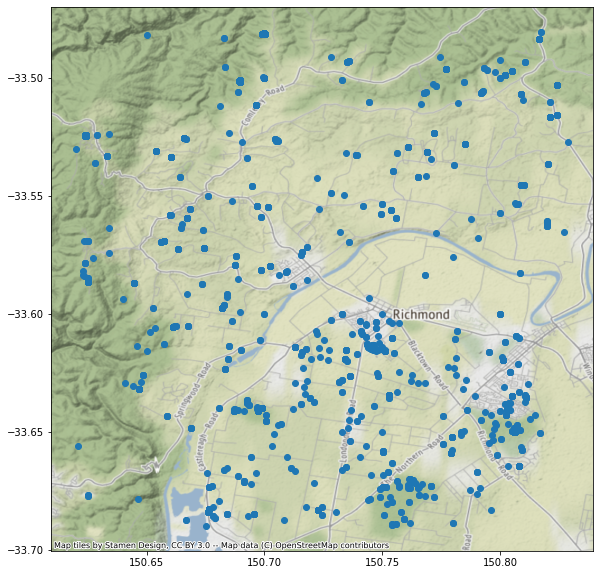

In [8]:
crs = {'init':'epsg:4326'}

geo_frogs = gpd.GeoDataFrame(
    frogs.reset_index(drop=True), 
    geometry=gpd.points_from_xy(frogs.decimalLongitude, frogs.decimalLatitude),
    crs=crs
)
ax = geo_frogs.plot(figsize=(10, 10))

# Add basemap
cx.add_basemap(ax, crs=crs)


### Frog Absence

Congratulations, you have successfuly found frogs! But in addition to knowing where frogs are, for the model that we plan to train we must also know where they aren't. To achieve this, we will assume that if a location has no observed frogs, that it actually has no frogs. This has some obvious flaws, but its a good start. Developing a smarter way to sample for frog absence could be an avenue worth persuing in your model optimisation process.

Firstly, we will add an `occurrenceStatus` attribute to indicate frog presence in the frog occurrence data we currently have. In addition, we'll simplify the dataframe to only include the location of each frog sighting, ignoring other information like species. 

In [19]:
frogs = (
    frogs
    [["decimalLatitude", "decimalLongitude"]]
    .assign(
        occurrenceStatus = 1
    )
)
frogs

,decimalLatitude,decimalLongitude,occurrenceStatus
0,-33.640336,150.687247,1
1,-33.609240,150.748344,1
2,-33.687430,150.708166,1
3,-33.567792,150.790437,1
4,-33.629142,150.713045,1
...,...,...,...
251,-33.533000,150.633000,1
252,-33.600000,150.733000,1
253,-33.600000,150.733000,1
254,-33.600000,150.733000,1


To sample for frog absence, we will perform a sliding window across the map above. If there are no frogs within the sliding region, we will save the midpoint of that region as a point where frogs do not occur. 

In [20]:
non_frogs = pd.DataFrame()

# Specify granularity of grid (50x50)
grid = np.array([50, 50])

# Calculate the step required to achieve granularity
step = np.array([max_lat - min_lat, max_lon - min_lon])/grid

# Define unit vectors
up = np.array([0, 1])
right = np.array([1, 0])

# Bottom corner of entire bounding box
bbox_bottom_corner = np.array([min_lon, min_lat])

bottom_corner = bbox_bottom_corner
for i in range(grid[0]):
    for j in range(grid[1]):
        
        # Define grid unit
        coords = [
            tuple(bottom_corner), 
            tuple(bottom_corner + step*up), 
            tuple(bottom_corner + step), 
            tuple(bottom_corner + step*right)
        ]
        grid_unit = Polygon(coords)
        
        # count all frogs that intersect with this region
        num_frogs = sum(geo_frogs.intersects(grid_unit))
        
        if num_frogs == 0:
            midpoint = bottom_corner + step/2
            non_frogs = non_frogs.append({'decimalLatitude':midpoint[1], 'decimalLongitude':midpoint[0]}, ignore_index=True)
                
        # move bottom corner to next grid unit
        bottom_corner = bbox_bottom_corner + step*np.array([i, j])
        

To avoid class imbalance, we take only as many non-frogs as we have frogs.

In [22]:
np.random.seed(420)
non_frogs = (
    non_frogs
    # Take as many non-frogs as there are frogs
    .sample(len(frogs))
    # Assign new columns
    .assign(
        occurrenceStatus = 0
    )
    [[ "decimalLatitude", "decimalLongitude", "occurrenceStatus"]]
)
non_frogs

,decimalLatitude,decimalLongitude,occurrenceStatus
1069,-33.6291,150.7229,0
2031,-33.6417,150.8195,0
1811,-33.6879,150.7985,0
1346,-33.6501,150.7523,0
1403,-33.5619,150.7565,0
...,...,...,...
1264,-33.4905,150.7397,0
32,-33.5409,150.6221,0
290,-33.6375,150.6473,0
1084,-33.5577,150.7229,0


### Visualise final dataset

Below is a map of our final dataset. The frog occurrences are green points, while the frog-absent points are yellow.

Text(0.5, 1.0, 'Frogs (Green) and Frog Absence (Yellow) for Richmond NSW (1890-2021)')

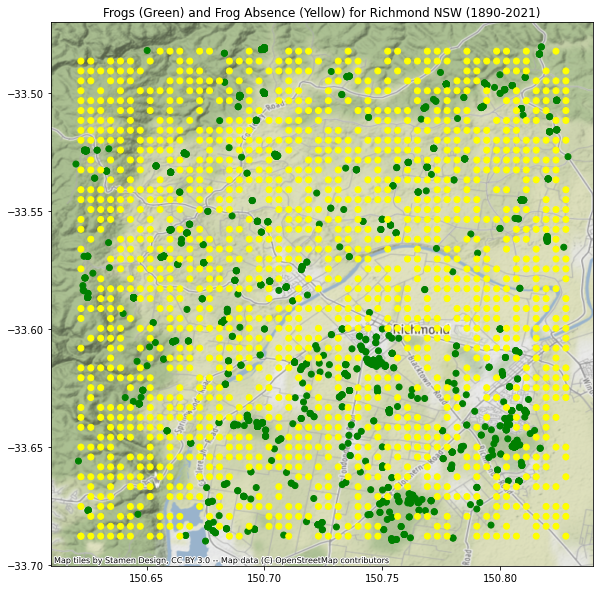

In [29]:
crs = {'init':'epsg:4326'}

all_data = (
    frogs
    .append(non_frogs)
    .reset_index(drop=True)
)

geo_all_data = gpd.GeoDataFrame(
    all_data, 
    geometry=gpd.points_from_xy(all_data.decimalLongitude, all_data.decimalLatitude),
    crs=crs
)

geo_all_data = geo_all_data.assign(
    colour = lambda x: np.where(x.occurrenceStatus == 0, 'yellow', 'green')   
)

ax = geo_all_data.plot(figsize=(10, 10), color=geo_all_data.colour)

# Add basemap
cx.add_basemap(ax, crs=crs)

ax.set_title(f'Frogs (Green) and Frog Absence (Yellow) for Richmond NSW (1890-2021)')

### Prepare and save to file

Finally, we are left with a table containing the geolocations of frog sightings, as well as locations of frog absence in Richmond, NSW. These data will be the ground truth of our algorithm.

In [31]:
all_data.drop('geometry', 1).to_csv("richmond_frogs.csv", index=None)